### Importation des bilbliothèques

In [4]:
import matplotlib.pyplot as plt

import numpy as np

import cv2
import time
from skimage import color, transform
from skimage.feature import hog
import imutils

import joblib

Taille de nos patches, associée à notre modèle

In [5]:
positive_patches_shape = (62, 47)

L'image étudiée est de taille (150, 267)


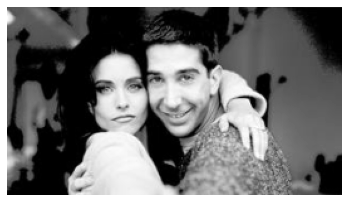

In [139]:
test_image = cv2.imread('img/ew-courtney-david.jpg') 

test_image = color.rgb2gray(test_image)

# Paramètre dont on étudiera l'influence
(H_MAX, W_MAX) = (300, 600)

if test_image.shape[0] > H_MAX or test_image.shape[1] > W_MAX:
    s = min(H_MAX / test_image.shape[0], W_MAX / test_image.shape[1])
    test_image = transform.rescale(test_image, s)
    
test_image = test_image[:150]
    
print("L'image étudiée est de taille {}".format(test_image.shape))

plt.imshow(test_image, cmap="gray")
plt.axis('off');

### Image pyramid, sliding window

*Momentanément, on n'utilise pas la pyramide d'images*

In [7]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        
        if image.shape[0] < minSize[0] or image.shape[1] < minSize[1]:
            break
        
        yield image

In [8]:
def sliding_window(img, patch_size, istep=4, jstep=4, scale=1.0):
    
    Ni, Nj = (int(scale * s) for s in patch_size)
    # La sliding window a une taille Ni*Nj
    
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

### Extraction des patches

On a un total de 1144 patches.

Temps d'exécution: 1.22 secondes



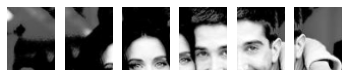

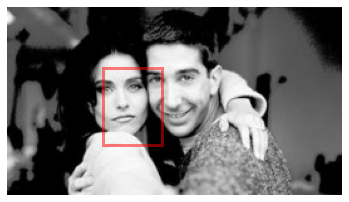

In [140]:
indices, patches = [], []

start = time.time()

'''
pyrlayers = 0
for (i, resized) in enumerate(pyramid(test_image)):
    if resized.shape > positive_patches_shape:
        # On applique la sliding window sur la couche de la pyramide en cours
        print(resized.shape)
        pyrindices, pyrpatches = zip(*sliding_window(resized, positive_patches_shape, i+1, scale=1.0))
        indices += pyrindices
        patches += pyrpatches
        pyrlayers += 1

    
print("La pyramide présente {} couches.".format(pyrlayers))

'''

s = 1.0

indices, patches = zip(*sliding_window(test_image, positive_patches_shape, scale=s))

Ni, Nj = (int(s * e) for e in positive_patches_shape)

print("On a un total de {} patches.".format(len(patches)))
    
indices = np.array(indices)


fig, axs = plt.subplots(1,6)
for i in range(6):
    axs[i].imshow(patches[i*60], cmap='gray')
    axs[i].axis('off')

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
    
ax.add_patch(plt.Rectangle(indices[1000], Nj, Ni, edgecolor='red', alpha=0.5, lw=3, facecolor='none'))
 
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

print("\nTemps d'exécution: {} secondes\n".format(round(time.time()-start, 2)))

*Momentanément évité*
Mise en évidence du souci sur la localisation des régions.
Les indices ne collent pas à la bonne taille d'image.

[184 224]


(-0.5, 46.5, 61.5, -0.5)

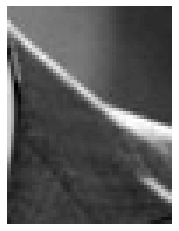

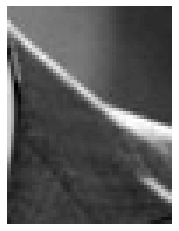

In [89]:
fig, ax = plt.subplots()
print(indices[3000])
ax.imshow(patches[3000], cmap='gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(test_image[indices[3000][0]: indices[3000][0]+Ni, indices[3000][1]: indices[3000][1]+Nj] , cmap='gray')
ax.axis('off')

### Prédiction

In [141]:
# Chargement du modèle
filename = 'temp_model.sav'
loaded_model = joblib.load(filename)

start = time.time()

# Prédictions
labels = loaded_model.predict(patches_hog)

pred = []
for k in range(len(indices)):
    if labels[k] == 1:
        (i, j) = indices[k]
        pred.append((j, i, loaded_model.decision_function(patches_hog)[k]))

print("\n{} zones positives trouvées.".format(int(labels.sum())))
print("\nTemps d'exécution: {} secondes".format(round(time.time()-start, 5)))


39 zones positives trouvées.

Temps d'exécution: 0.10649 secondes


### Affichage des résultats

  Zone Confiance 
     1:  0.72      
     2:  0.19      
     3:  0.12      
     4:  0.16      
     5:  0.38      
     6:  0.84      
     7:  0.15      
     8:  0.25      
     9:  2.63      
    10:  2.49      
    11:  0.84      
    12:  0.79      
    13:  2.35      
    14:  2.92      
    15:  0.79      
    16:  0.29      
    17:  2.3       
    18:  2.14      
    19:  0.66      
    20:  3.09      
    21:  5.4       
    22:  2.49      
    23:  1.33      
    24:  1.45      
    25:  0.44      
    26:  3.05      
    27:  4.7       
    28:  1.7       
    29:  1.07      
    30:  2.21      
    31:  0.26      
    32:  0.07      
    33:  0.06      
    34:  1.82      
    35:  0.0       
    36:  0.05      
    37:  0.49      
    38:  0.26      
    39:  0.34      
62 47


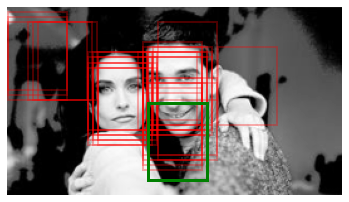

In [142]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

indices = np.array(indices)

print("{:>6} {:<10}".format("Zone", "Confiance"))
for (k, (j, i, conf)) in enumerate(pred):
    print("{:>6}:  {:<10}".format(k+1, round(conf,2)))
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
        
best = max(pred, key=lambda item: item[1])
ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='green',
                               alpha=1, lw=3, facecolor='none'))

print(Ni, Nj)

### Non-maxima suppression
On doit combiner les patches qui se superposent

In [24]:
def non_max_suppression(boxes, h=66, w=52, seuil=0.3):
    if len(boxes) == 0:
        return []
    
    l = []
    
    y1 = boxes[:,0]
    x1 = boxes[:,1]
    y2 = h + y1
    x2 = w + x1
    
    # On calcule les aires des boxes
    aires = (x2 - x1 + 1) * (y2 - y1 + 1)    # le + 1 pour éviter la division par zéro
    
    indexes = boxes[:,2]
    
    indexes = np.argsort(indexes)
    
    while len(indexes) > 0:
        lst = len(indexes) - 1
        i = indexes[lst]
        l.append(i)
        
        # On cherche les intersections entre la box courante et toutes les autres
        y1_inter = np.maximum(y1[i], y1[indexes[:lst]])
        x1_inter = np.maximum(x1[i], x1[indexes[:lst]])
        y2_inter = np.minimum(y2[i], y2[indexes[:lst]])
        x2_inter = np.minimum(x2[i], x2[indexes[:lst]])
        
        h_inter = np.maximum(0, y2_inter - y1_inter + 1)
        w_inter = np.maximum(0, x2_inter - x1_inter + 1)
        aires_inter = (w_inter * h_inter)
   
        overlap = aires_inter / aires[indexes[:lst]]
        
        indexes = np.delete(indexes, np.concatenate(([lst], np.where(overlap > seuil)[0])))
        
    return boxes[l]
        

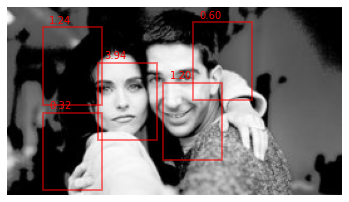

In [138]:
pred = np.array(pred)

nms_pred = non_max_suppression(pred, h=Ni, w=Nj, seuil=0.3)

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for (j, i, conf) in nms_pred:
    rect = plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.5, lw=2, facecolor='none')
    ax.add_patch(rect)
    ax.text(j+5, i-3, f'{conf:.2f}', color='red')

plt.show()